In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [2]:
tf.keras.preprocessing.image_dataset_from_directory

<function keras.src.utils.image_dataset.image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, **kwargs)>

In [36]:
img_size=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=5

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle=True,
    image_size=(img_size,img_size),
    batch_size=BATCH_SIZE
    
)

Found 1540 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato_Early_Blight_Leaf', 'Potato_Healthy_Leaf', 'Potato_Late_Blight_leaf']

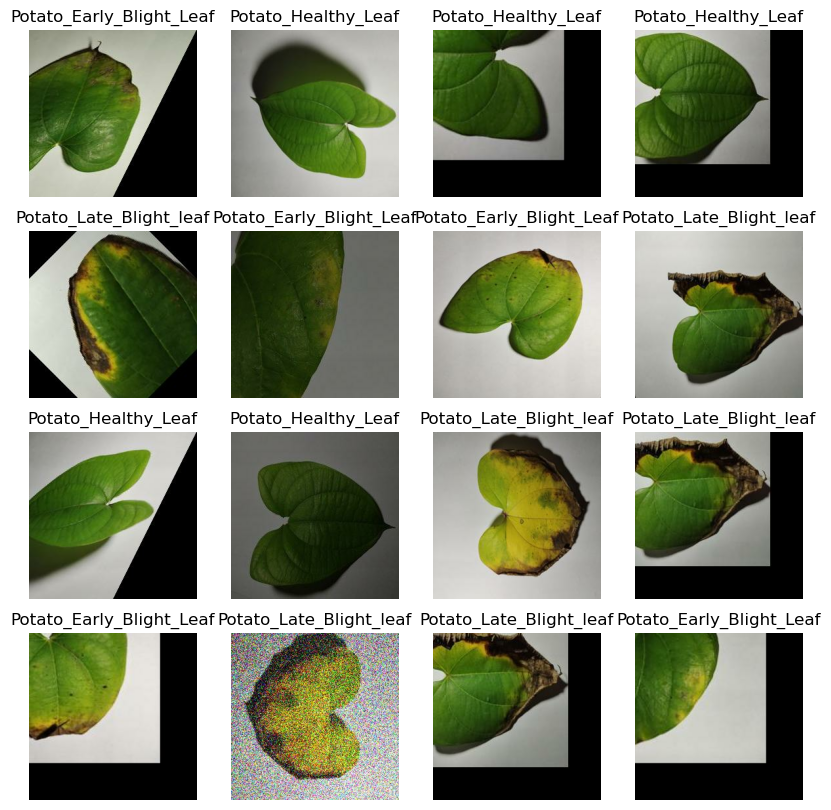

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
        
    
#     print(image_batch.shape)
#     print(labels_batch.numpy())

In [7]:
len(dataset)

49

In [8]:
# print(labels_batch)

In [9]:
train_size=0.8
len(dataset)*train_size

39.2

In [10]:
train_ds=dataset.take(39)
len(train_ds)

39

In [11]:
test_ds=dataset.skip(39)
len(test_ds)

10

In [12]:
val_size=0.1
len(dataset)*val_size

4.9

In [13]:
val_ds=test_ds.take(4)
len(val_ds)

4

In [14]:
test_ds=test_ds.skip(4)
len(test_ds)

6

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
#     assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

39

In [18]:
len(val_ds)

4

In [19]:
len(test_ds)

6

In [20]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
input_shape = (BATCH_SIZE, img_size, img_size, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)



In [25]:
history=model.fit(
    
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
39/39 [==============================] - 97s 2s/step - loss: 1.0033 - accuracy: 0.5123 - val_loss: 0.7654 - val_accuracy: 0.6797
Epoch 2/5
39/39 [==============================] - 87s 2s/step - loss: 0.5442 - accuracy: 0.7828 - val_loss: 0.4051 - val_accuracy: 0.8594
Epoch 3/5
39/39 [==============================] - 89s 2s/step - loss: 0.3052 - accuracy: 0.8910 - val_loss: 0.1607 - val_accuracy: 0.9453
Epoch 4/5
39/39 [==============================] - 77s 2s/step - loss: 0.0816 - accuracy: 0.9713 - val_loss: 0.0218 - val_accuracy: 0.9922
Epoch 5/5
39/39 [==============================] - 89s 2s/step - loss: 0.0182 - accuracy: 0.9943 - val_loss: 0.0073 - val_accuracy: 1.0000


In [26]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 3s 344ms/step - loss: 0.0039 - accuracy: 1.0000


In [27]:
scores

[0.0039036560337990522, 1.0]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 39}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
type(history.history['loss'])

list

In [32]:
len(history.history['loss'])

5

In [33]:
history.history['loss'][:5]

[1.0033435821533203,
 0.5441797375679016,
 0.30522412061691284,
 0.08160191774368286,
 0.018212148919701576]

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

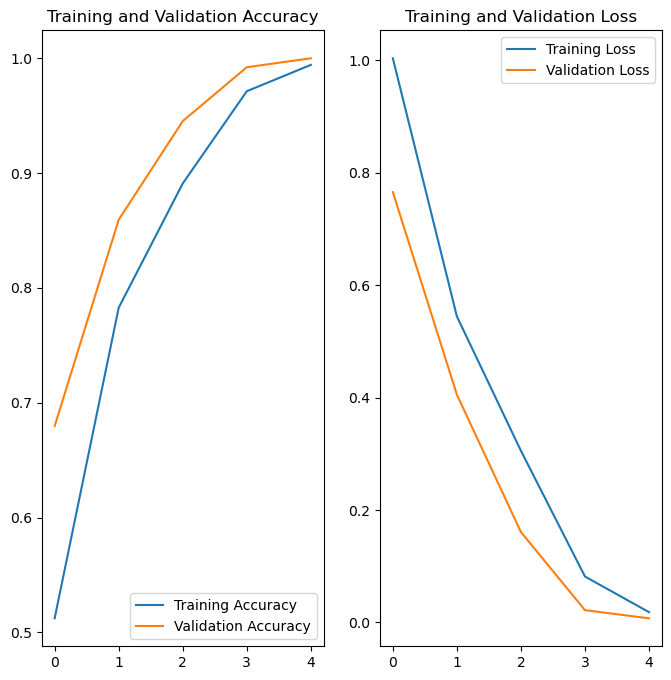

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
image_batch[0].numpy().astype('uint8')

array([[[134, 137, 118],
        [135, 138, 119],
        [135, 138, 119],
        ...,
        [154, 160, 146],
        [167, 173, 161],
        [170, 176, 164]],

       [[135, 138, 119],
        [135, 138, 119],
        [135, 138, 119],
        ...,
        [163, 169, 155],
        [170, 176, 164],
        [  0,   3,   0]],

       [[135, 138, 119],
        [135, 138, 119],
        [135, 138, 119],
        ...,
        [170, 176, 162],
        [146, 152, 140],
        [ 15,  21,   9]],

       ...,

       [[189, 192, 175],
        [189, 192, 175],
        [189, 192, 175],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[189, 192, 175],
        [189, 192, 175],
        [189, 192, 175],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[188, 191, 174],
        [189, 192, 175],
        [189, 192, 175],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [50]:
# labels_batch[0].numpy()
model.predict(image_batch)

1/1 [==============================] - 1s 1s/step


array([[9.9999237e-01, 5.4671527e-06, 2.1976668e-06],
       [9.9209547e-03, 9.9005729e-01, 2.1742386e-05],
       [1.6882837e-04, 9.9981350e-01, 1.7752953e-05],
       [8.1684659e-05, 9.9974638e-01, 1.7201898e-04],
       [2.5412724e-03, 3.9918123e-06, 9.9745470e-01],
       [9.9218971e-01, 6.1991392e-04, 7.1903700e-03],
       [9.9999785e-01, 2.0423468e-06, 9.6356892e-08],
       [8.1456928e-05, 2.0071202e-09, 9.9991858e-01],
       [6.3475757e-04, 9.9936420e-01, 1.0155529e-06],
       [2.4663963e-04, 9.9907303e-01, 6.8033108e-04],
       [6.7203132e-07, 1.9303621e-13, 9.9999928e-01],
       [1.4216639e-06, 9.0351801e-07, 9.9999762e-01],
       [9.9942845e-01, 2.7541441e-04, 2.9606128e-04],
       [2.2430711e-05, 4.0753742e-12, 9.9997759e-01],
       [6.2881307e-05, 2.4335804e-06, 9.9993467e-01],
       [9.2582095e-01, 4.3433756e-03, 6.9835730e-02],
       [1.7866257e-03, 9.9592316e-01, 2.2902102e-03],
       [9.9999952e-01, 1.2791643e-09, 4.2184115e-07],
       [2.2723464e-02, 1.675

first image to predict
actual label: Potato_Early_Blight_Leaf
1/1 [==============================] - 1s 679ms/step
predicted label: Potato_Early_Blight_Leaf


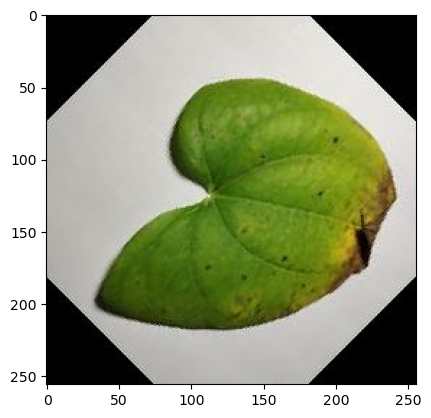

In [51]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [52]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    preds=model.predict(img_array)
    predicted_class=class_names[np.argmax(preds[0])]
    confidence=round(100*(np.max(preds[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 36ms/step


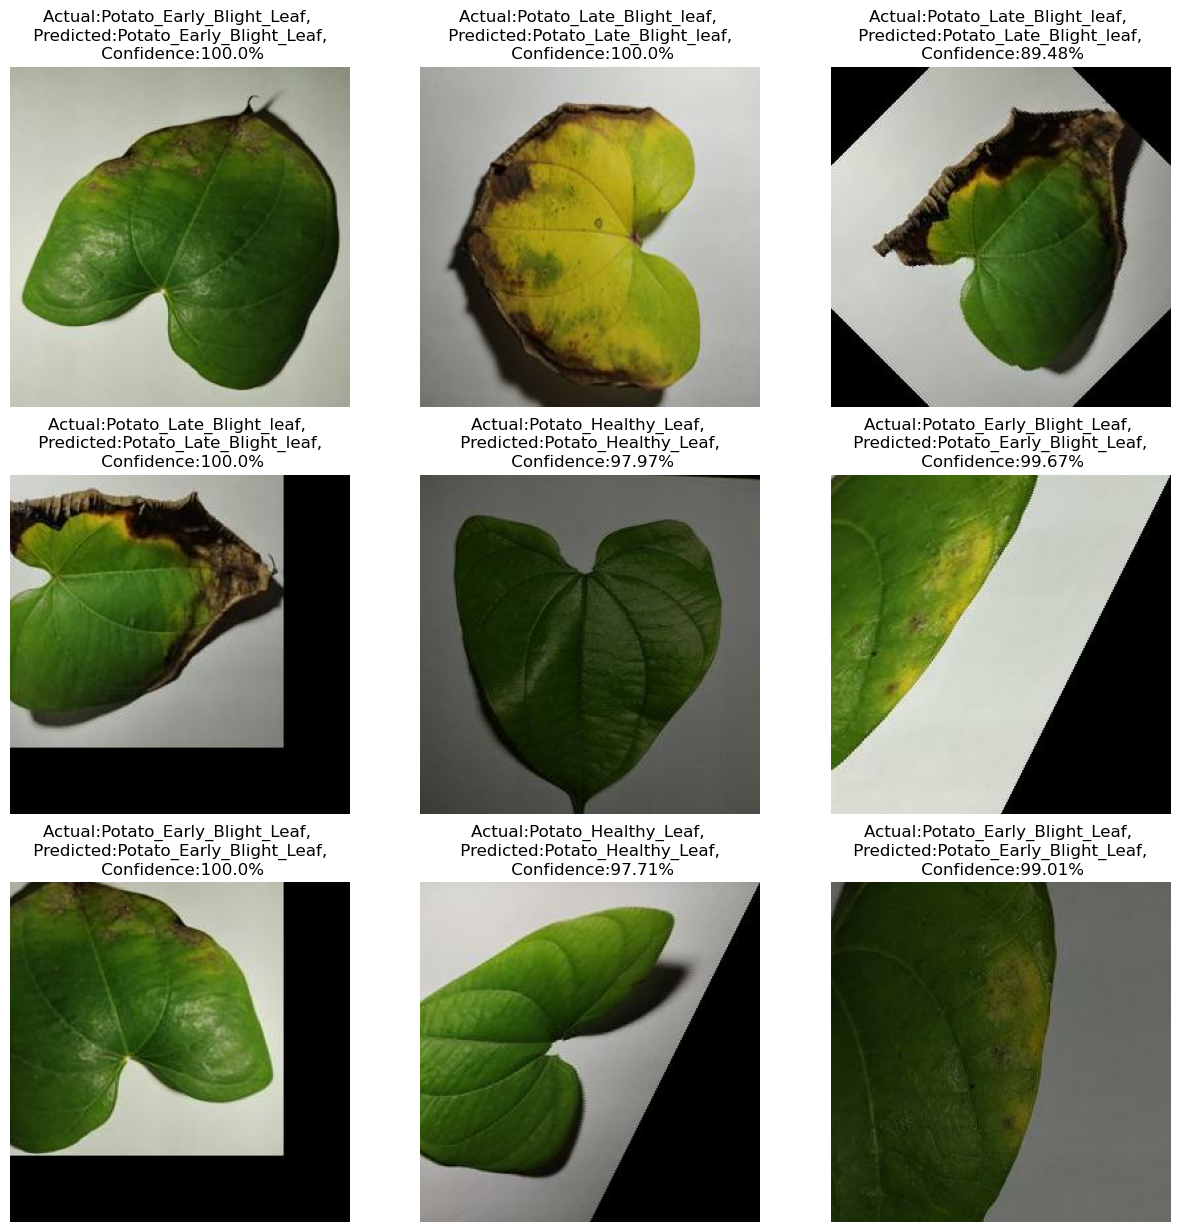

In [63]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class}, \n Predicted:{predicted_class}, \n Confidence:{confidence}%")
        plt.axis("off")
        

In [65]:
model_version=1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1\assets


INFO:tensorflow:Assets written to: ../model/1\assets


In [71]:
import os
os.listdir("../model/")

['1',
 'assets',
 'fingerprint.pb',
 'keras_metadata.pb',
 'saved_model.pb',
 'variables']

In [9]:
# import uvicorn
# import numpy as np
# from io import BytesIO
# from PIL import Image
# import tensorflow as tf
# from fastapi import FastAPI
# app = FastAPI()

# origins = [
#     "http://localhost",
#     "http://localhost:3000",
# ]
# app.add_middleware(
#     CORSMiddleware,
#     allow_origins=origins,
#     allow_credentials=True,
#     allow_methods=["*"],
#     allow_headers=["*"],
# )

# MODEL = tf.keras.models.load_model("../saved_model/1")

# CLASS_NAMES = ["Early Blight", "Late Blight", "Healthy"]

# @app.get("/ping")
# async def ping():
#     return "Hello, I am alive"

# def read_file_as_image(data) -> np.ndarray:
#     image = np.array(Image.open(BytesIO(data)))
#     return image

# @app.post("/predict")
# async def predict(
#     file: UploadFile = File(...)
# ):
#     image = read_file_as_image(await file.read())
#     img_batch = np.expand_dims(image, 0)
    
#     predictions = MODEL.predict(img_batch)

#     predicted_class = CLASS_NAMES[np.argmax(predictions[0])]
#     confidence = np.max(predictions[0])
#     return {
#         'class': predicted_class,
#         'confidence': float(confidence)
#     }

# if __name__ == "__main__":
#     uvicorn.run(app, host='localhost', port=8000)

In [11]:
# !pip install FastAPI

In [12]:
# !pip install uvicorn